# 载入数据集

In [1]:
import cv2
import numpy as np
from tqdm import tqdm

n = 25000
width = 224

X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n,), dtype=np.uint8)

for i in tqdm(range(n/2)):
    X[i] = cv2.resize(cv2.imread('train/cat.%d.jpg' % i), (width, width))
    X[i+n/2] = cv2.resize(cv2.imread('train/dog.%d.jpg' % i), (width, width))

y[n/2:] = 1

100%|██████████| 12500/12500 [00:45<00:00, 274.66it/s]


# 分为训练集和验证集

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

# 数据集可视化

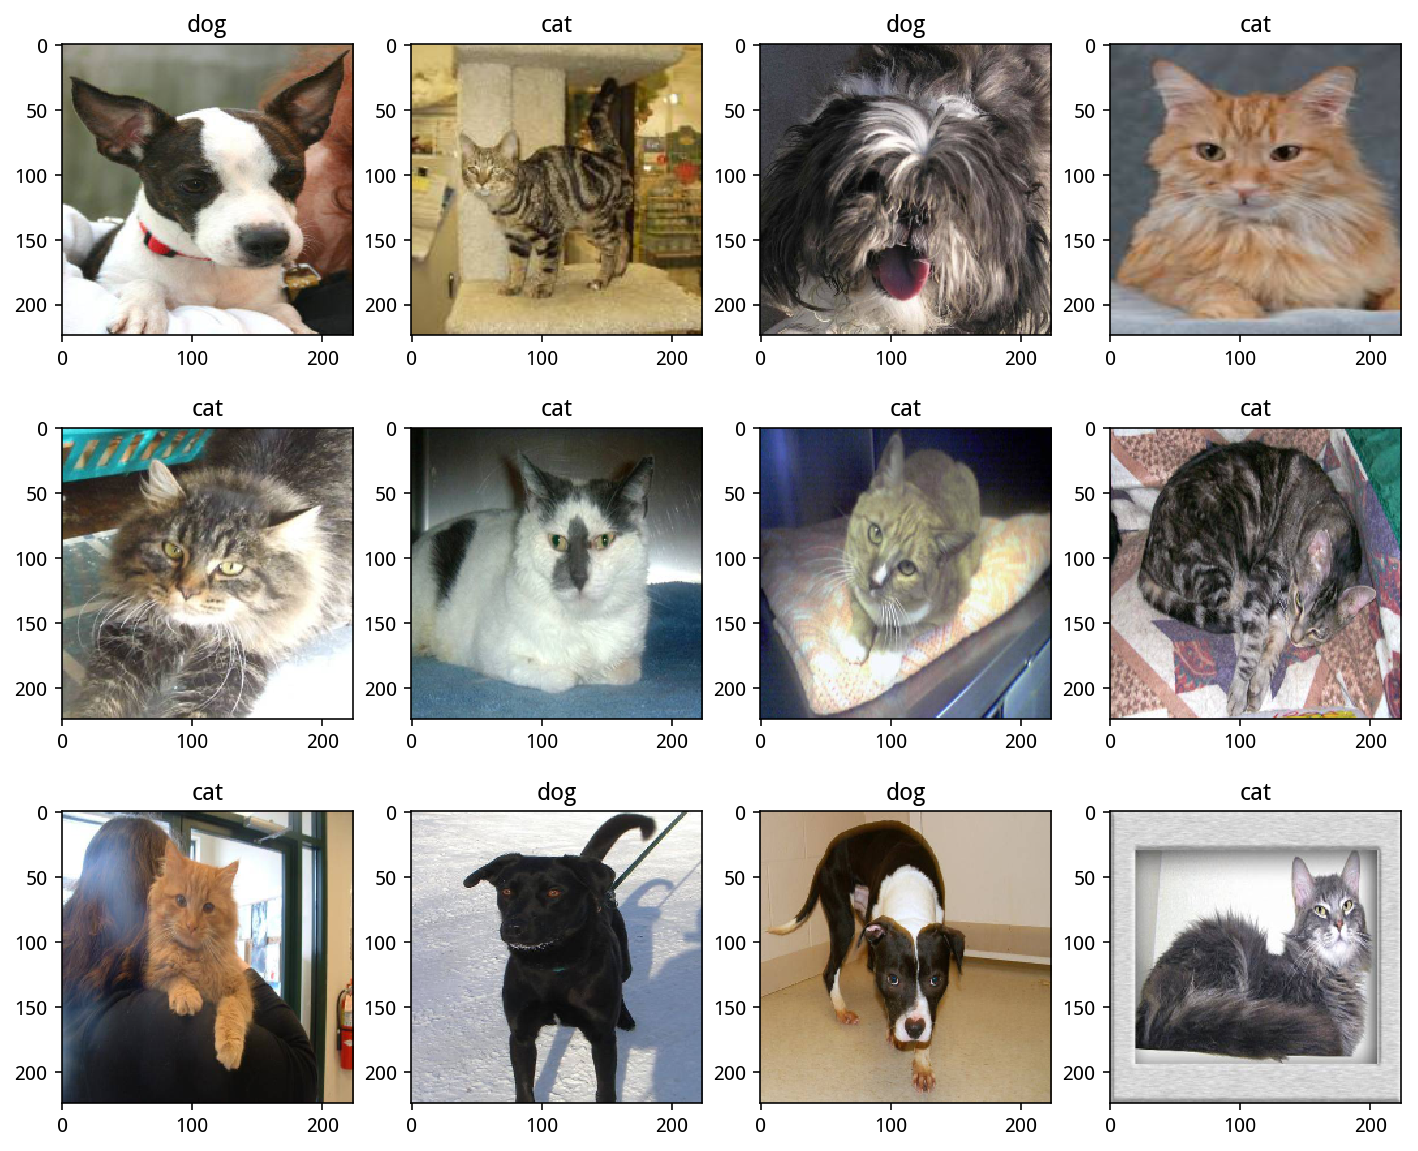

In [3]:
import random
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 10))
for i in range(12):
    random_index = random.randint(0, n-1)
    plt.subplot(3, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(['cat', 'dog'][y[random_index]])

# 搭建模型

In [4]:
from keras.layers import *
from keras.models import *
from keras.applications import VGG16

Using TensorFlow backend.


In [5]:
def preprocess_input(x):
    return x - [103.939, 116.779, 123.68]

In [6]:
cnn_model = VGG16(include_top=False, input_shape=(width, width, 3), weights='imagenet')

for layer in cnn_model.layers:
    layer.trainable = False

inputs = Input((width, width, 3))
x = inputs
x = Lambda(preprocess_input, name='preprocessing')(x)
x = cnn_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs, x)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

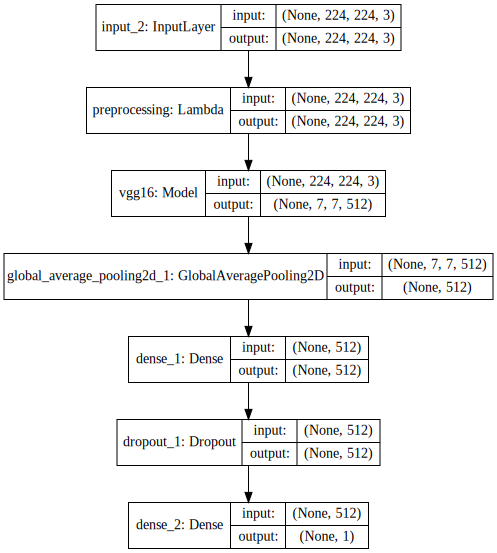

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [8]:
h = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_valid, y_valid))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 85s - loss: 0.1679 - acc: 0.9672 - val_loss: 0.0508 - val_acc: 0.9834
Epoch 2/10
20000/20000 [==============================] - 83s - loss: 0.0515 - acc: 0.9832 - val_loss: 0.0478 - val_acc: 0.9840
Epoch 3/10
20000/20000 [==============================] - 83s - loss: 0.0400 - acc: 0.9858 - val_loss: 0.0501 - val_acc: 0.9816
Epoch 4/10
20000/20000 [==============================] - 83s - loss: 0.0323 - acc: 0.9878 - val_loss: 0.0479 - val_acc: 0.9840
Epoch 5/10
20000/20000 [==============================] - 83s - loss: 0.0247 - acc: 0.9921 - val_loss: 0.0416 - val_acc: 0.9866
Epoch 6/10
20000/20000 [==============================] - 83s - loss: 0.0240 - acc: 0.9921 - val_loss: 0.0417 - val_acc: 0.9862
Epoch 7/10
20000/20000 [==============================] - 83s - loss: 0.0202 - acc: 0.9931 - val_loss: 0.0419 - val_acc: 0.9844
Epoch 8/10
20000/20000 [==============================]

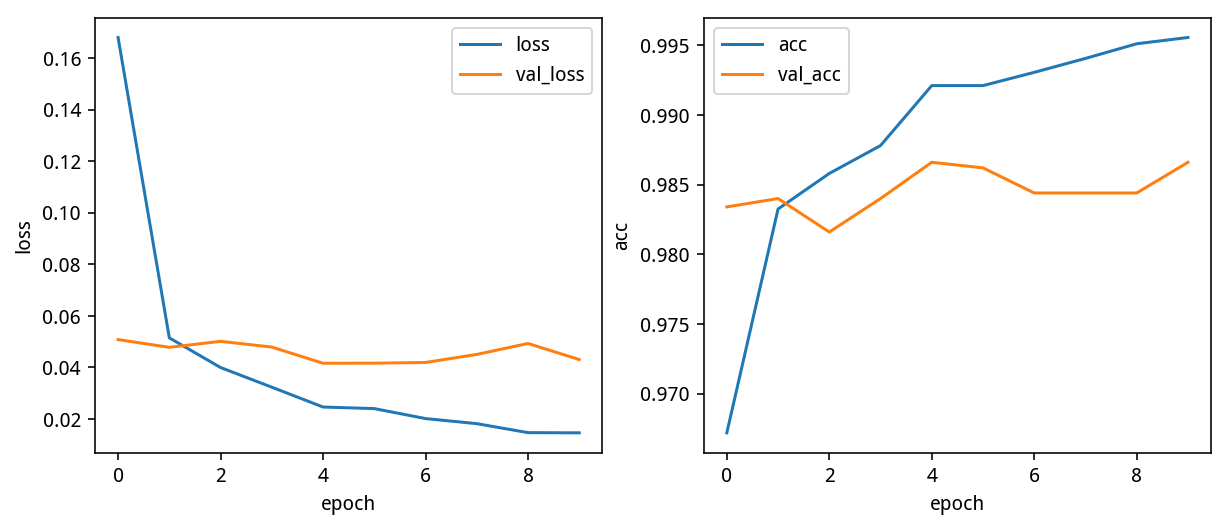

In [9]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

In [10]:
model.save('model.h5')

# 在测试集上预测并提交到 kaggle 评估

In [13]:
n = 12500
X_test = np.zeros((n, width, width, 3), dtype=np.uint8)

for i in tqdm(range(n)):
    X_test[i] = cv2.resize(cv2.imread('test/%d.jpg' % (i+1)), (width, width))

100%|██████████| 12500/12500 [00:25<00:00, 492.31it/s]


In [14]:
y_pred = model.predict(X_test, batch_size=128, verbose=1)

12500/12500 [==============================] - 41s    


In [25]:
import pandas as pd

df = pd.read_csv('sample_submission.csv')
df['label'] = y_pred.clip(min=0.005, max=0.995)
df.to_csv('pred.csv', index=None)